# <font color='red'>Examen Data Science</font>

![title](img/st.jpeg)

Escribir su Nombre y Apellido a continuación

Nombre: Diego Demian
Apellido: Vallejos

# Sección A - Desafíos Técnicos

## <font color='red'>1 -Python</font>

### py-1) Vectores, Clases y Objetos

Desarrollar una clase en python que, al instanciar, reciba un vector **weights** y que tenga la siguiente funcionalidad:


* Desarrollar el método **set_weights** que pueda sobrescribir los valores del atributo `weights`
* Desarrollar el método **dot** que permita multiplicar el vector `weigths` por un vector de entrada. (producto escalar)
* Desarrollar el método **predict** que utilice la salida del método dot y lo pasé por la función ReLu. <a href=https://es.wikipedia.org/wiki/Rectificador_(redes_neuronales)>Función Relu</a>  
* Desarrollar otra clase que herede el comportamiento de la clase anterior y que además:
  * Reciba un parametro adicional: `bias` (int64)
  * Redefina el método **dot** y al producto le sume el atributo `bias`

In [44]:
import numpy as np
weights = np.array([-4,3,1,-2])

In [45]:
# Escriba aquí su respuesta

class Model(): #Sin bias
    def __init__(self, weights):
        self.weights = weights

    def set_weights(self, weights):
        self.weights = weights

    def dot(self, x):
        return np.dot(self.weights, x)
    
    def predict(self, x):
        return np.maximum(0, self.dot(x))
    

class Biased_Model(Model):
    def __init__(self, weights, bias: int):
        super().__init__(weights)
        self.bias = bias

    def dot(self, x):
        return np.dot(self.weights, x) + self.bias

def relu(X):
   return np.maximum(0,X)

### py-2) Unit test

Desarrollar un test unitario que permita evaluar los métodos de la clase base. 

In [46]:
# Escriba aquí su respuesta
import unittest

class TestModel(unittest.TestCase):
    def setUp(self):
        self.weights_array = np.array([1, 2, 3])
        self.test_weights = Model(self.weights_array)

    def test_set_weights(self):
        new_weights = np.array([4, 5, 6])
        self.test_weights.set_weights(new_weights)
        np.testing.assert_array_equal(self.test_weights.weights, new_weights)

    def test_dot(self):
        x = np.array([4, 5, 6])
        expected_result = np.dot(self.weights_array, x)
        self.assertEqual(self.test_weights.dot(x), expected_result)

    def test_predict_positive(self):
        x = np.array([1, 1, 1])
        expected_result = np.maximum(0, np.dot(self.weights_array, x))
        self.assertEqual(self.test_weights.predict(x), expected_result)

    def test_predict_negative(self):
        x = np.array([-1, -1, -1])
        expected_result = np.maximum(0, np.dot(self.weights_array, x))
        self.assertEqual(self.test_weights.predict(x), expected_result)


In [48]:
testing = TestModel()
testing.setUp()
testing.test_set_weights()
testing.test_dot()
testing.test_predict_positive()
testing.test_predict_negative()


## <font color='red'>2- SQL</font>

Para el siguiente ejercicio se tiene una base de datos que tiene el siguiente DER:

![title](img/img_der.png)


* Persona (id) puede tener muchas Tarjetas (se relaciona a través de `id_titular`)
* Una Compra siempre es realizada con una única tarjeta
* (EXTRA) La tabla Compra posee un histórico de más de 10 años y varias decenas de millones de registros por lo que las consultas a esta entidad pueden tardar varios minutos si no están correctamente optimizadas.

### sql-1) Query

Obtener los número de tarjeta que no tengan consumos en el último mes pero que pertenecen a personas que hayan comprado al menos un total de $5000 en el último mes en los rubros (FARMACIA y SUPERMERCADOS) en conjunto. (Si es posible, tener en cuenta el punto EXTRA mencionado previamente).


In [8]:
# Escriba aquí su respuesta
print(' Cuando tenemos una tabla con muchos registros lo mejor es crear un index para poder acceder a los datos de manera más rápida.')

query_respuesta = """
CREATE INDEX idx_compra_fecha_compra ON compra(fecha_compra);
CREATE INDEX idx_compra_nro_tarjeta ON compra(nro_tarjeta);
CREATE INDEX idx_compra_rubro ON compra(rubro);
CREATE INDEX idx_tarjeta_nro_tarjeta ON tarjeta(nro_tarjeta);
CREATE INDEX idx_tarjeta_id_titular ON tarjeta(id_titular);



WITH tarjetas_sin_compras_utlimo_mes AS (
SELECT t.nro_tarjeta 
FROM Tarjetas AS t
LEFT JOIN (SELECT nro_tarjeta FROM compra WHERE fecha_compra >= DATEADD(MONTH, -1, GETDATE())) AS c
ON t.nro_tarjeta = c.nro_tarjeta
WHERE c.nro_tarjeta IS NULL
)

#Hasta aca creamos indices para las tablas de compra y tarjeta, para poder acceder a los datos de manera mas eficiente. Luego creamos una tabla temporal que nos trae los numeros de tarjeta que no realizaron compras en el ultimo mes.
#Siendo la logica a utilizar hacer un Left Join (que trae los registros que se encuenten en la tabla de la "izquiera" y las coincidentes de la tabla de la "derecha"), esto genera que tengamos ahora todos los numeros de tarjeta
# y solo los que realizaron compras en el ultimo mes. Luego filtramos los que no realizaron compras en el ultimo mes (donde el campo numero de tarjeta es nulo).

SELECT tsc.nro_tarjeta
FROM tarjetas_sin_compras_ultimo_mes tsc
INNER JOIN Tarjetas t ON tsc.nro_tarjeta = t.nro_tarjeta
INNER JOIN (
SELECT t.id_titular
FROM Compra AS c
INNER JOIN Tarjeta AS t ON C.nro_tarjeta = t.nro_tarjeta
WHERE c.fecha_compra >= DATEADD(MONTH, -1, GETDATE())
AND c.rubro IN ('FARMACIA', 'SUPERMERCADO')
GROUP BY t.id_titular
HAVING SUM(c.monto) > 5000
) AS ct ON t.id_titular = ct.id_titular;

#Esta parte es la de la query principal, aca me traigo los numeros de tarjeta de la tabla temproral que no tiene consumos en el ultimo mes uniendolas con un INNER JOIN (me trae solo los registros que este en ambas tablas)
#a la tabla de tarjetas. 
#Hasta aca tengo todos los numeros de tarjeta que no realizaron compras en el ultimo mes y lo uno con la tabla de tarjetas solo porque luego uso t.id_titular y no esta disponible en el cotexto, asi que por ello debo hacer esta union.
#Ahora hago una INNER JOIN con una subconsulta que me trae el id_titular de las compras que se realizaron en el ultimo mes en los subros farmacia y supermercado y que superen los 5000 pesos.

Con esto deberia tener el resultado deseado. La mejora de eficiencia viene del lado del indexado y los joins que se utilizan, ya que se utilizan los que mejor rendimiento tienen en este caso.

"""



 Cuando tenemos una tabla con muchos registros lo mejor es crear un index para poder acceder a los datos de manera más rápida.


### sql-2) Explicar el resultado de la siguiente query

* ¿Qué se obtiene cómo resultado?
* ¿Quiénes son P1, P2 y P3?
* (EXTRA) Si supiera que la tabla persona se carga completa todos los días del año, cada día teniendo una foto guardada con una valor distinto dentro de una variable llamada partition_date. Por ej: uno puede consultar todos los ids de la fecha 2021-05-27 o de la fecha que quiera. ¿Cambiaría algo la siguiente query si quisiera obtener el mismo resultado para la última fecha disponible?


 <font color='blue'>**SELECT**</font> P1.dni,  <font color='red'>COUNT</font> ( <font color='red'>DISTINCT</font>  ( P2.id ) )\
<font color='blue'>**FROM** </font> Persona P1 \
<font color='blue'>**JOIN**</font> Persona P2 on P1.id_padre = P2.id \
<font color='blue'>**JOIN**</font>  Persona P3 on P2.id_padre = P3.id \
<font color='blue'>**WHERE**</font>  P3.sexo = 'MASCULINO' \
<font color='blue'>**GROUP BY**</font>  P1.dni 

In [ ]:
# Escriba aquí su respuesta

Respuesta_query = """
Esta consulta trae el numero de DNI de la persona 1 y el numero de padres unicos que tiene el abuelo masculino de la persona 1.
P1, P2 y P3 son las tablas de personas, donde P1 es la tabla de personas, P2 es la tabla de padres y P3 es la tabla de abuelos.
"""

mejora_query = """
WITH LatestDate AS (
    SELECT MAX(partition_date) AS last_date
    FROM Persona
),
FilteredPersona AS (
    SELECT *
    FROM Persona
    WHERE partition_date = (SELECT last_date FROM LatestDate)
)
SELECT P1.dni, COUNT(DISTINCT(P2.id))
FROM FilteredPersona P1
JOIN FilteredPersona P2 ON P1.id_padre = P2.id
JOIN FilteredPersona P3 ON P2.id_padre = P3.id
WHERE P3.sexo = 'MASCULINO'
GROUP BY P1.dni;


"""

# Sección B - Desafío Machine Learning

#### Enunciado Parte Práctica

El ejercicio consiste en realizar una clasificación de intención de compra online. Para ello se dispondrá de un dataset **online_shoppers_intention.csv** el cual consta de **12.330** registros y **18** columnas
* El target es la columnna **Revenue** 

Para completar el desafío se deberá:
* Realizar un análisis exploratorio de los datos
* Explicar la elección del algoritmo utilizado
* Explicar los resultados obtenidos (Métricas)
* Explicar cuales son las variables que más afectan a la predicción.
* Contestar las siguientes preguntas:
  * *¿El modelo final elegido es bueno? Justificar*
  * *¿Existe overfitting o underfitting?* 

⚠️**ACLARACIONES:**⚠️

- Se tendrá en cuenta la prolijidad del informe. 
- Se tendrá en cuenta la legibilidad del código.
- De ser necesario, dejar asentado los supuestos utilizados por escrito.

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import seaborn as sns

In [70]:
df = pd.read_csv('online_shoppers_intention.csv')

### Primero le damos una mirada general al dataset

In [76]:
# Escriba el código aquí
print('------------------Primeros 5 registros------------------')
display(df.head())
print('------------------Estadísticas del dataset------------------')
display(df.describe())
print('------------------Nulos del dataset------------------')
display(df.isna().sum()) 

------------------Primeros 5 registros------------------


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


------------------Estadísticas del dataset------------------


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214,0.016813,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


------------------Nulos del dataset------------------


Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

## Procedemos a hacer el EDA

### Revenue

Text(0.5, 1.0, 'Revenue')

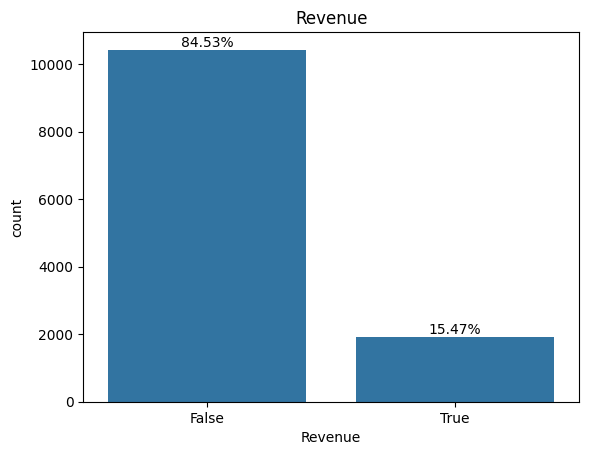

In [41]:
ax = sns.countplot(data=df, x='Revenue')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height/len(df)*100:.2f}%', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')
plt.title('Revenue')


### Weekend

Text(0.5, 1.0, 'Weekend')

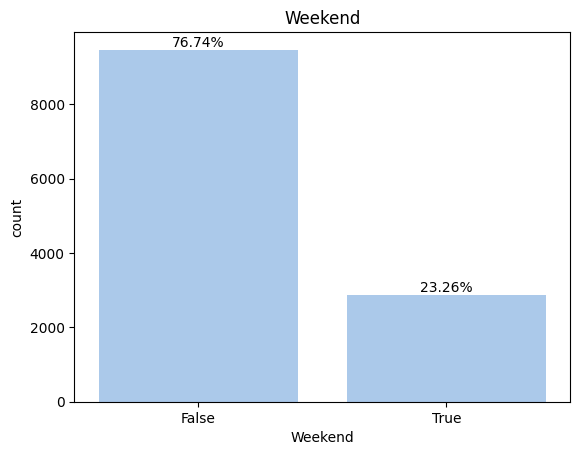

In [135]:
sns.set_palette("pastel")

ax = sns.countplot(data=df, x='Weekend')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height/len(df)*100:.2f}%', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')
plt.title('Weekend')

### ProductRelated

------------------Distribución de ProductRelated_Duration------------------


,count,mean,std,min,25%,50%,75%,max
Revenue,,,,,,,,
False,10422.0,1069.987809,1803.797757,0.0,151.00000,510.19000,1331.816667,63973.52223
True,1908.0,1876.209615,2312.214392,0.0,541.90625,1109.90625,2266.011310,27009.85943


------------------Distribución de ProductRelated------------------


,count,mean,std,min,25%,50%,75%,max
Revenue,,,,,,,,
False,10422.0,28.714642,40.744717,0.0,6.0,16.0,35.0,705.0
True,1908.0,48.210168,58.267365,0.0,15.0,29.0,57.0,534.0


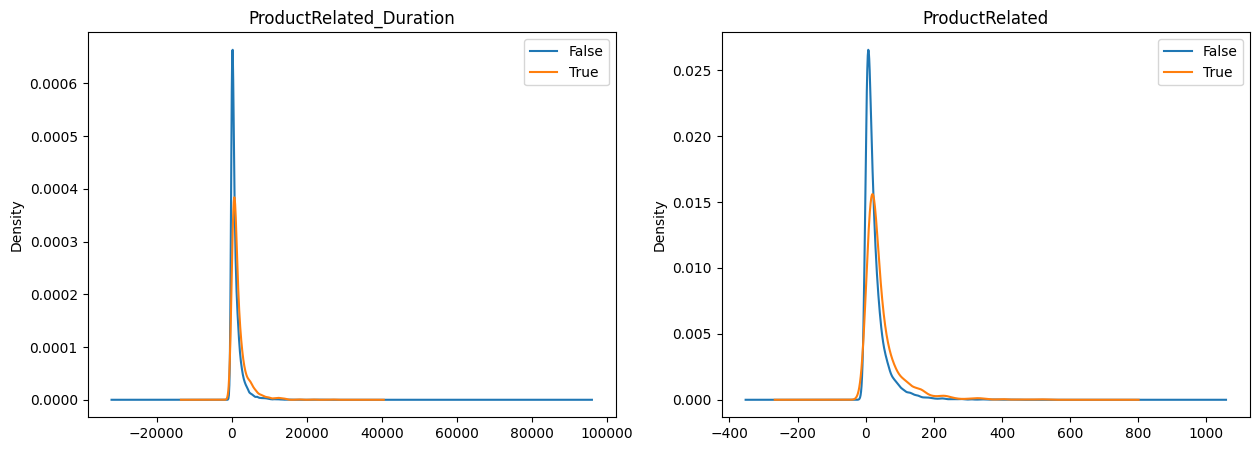

In [134]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

print('------------------Distribución de ProductRelated_Duration------------------')
df.groupby('Revenue')['ProductRelated_Duration'].plot(kind='kde', legend=True, ax=ax1)
display(df.groupby('Revenue')['ProductRelated_Duration'].describe())
print('------------------Distribución de ProductRelated------------------')
df.groupby('Revenue')['ProductRelated'].plot(kind='kde', legend=True, ax=ax2)
display(df.groupby('Revenue')['ProductRelated'].describe())


ax1.set_title('ProductRelated_Duration')
ax2.set_title('ProductRelated')

plt.show()

### Visitor Type

In [105]:
df.VisitorType.value_counts() #este esta interesante para analizar

VisitorType
Returning_Visitor    10551
New_Visitor           1694
Other                   85
Name: count, dtype: int64

### Month

In [111]:
df_revenue = df[df['Revenue'] == True]
df_not_revenue = df[df['Revenue'] == False]

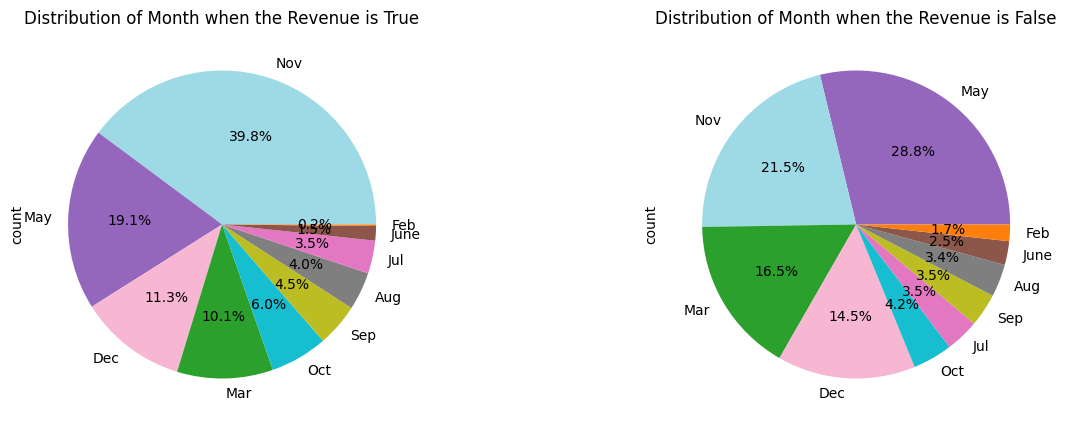

In [130]:
# Define a consistent color map for each month
month_colors = {
    'Jan': '#1f77b4', 'Feb': '#ff7f0e', 'Mar': '#2ca02c',
    'Apr': '#d62728', 'May': '#9467bd', 'June': '#8c564b',
    'Jul': '#e377c2', 'Aug': '#7f7f7f', 'Sep': '#bcbd22',
    'Oct': '#17becf', 'Nov': '#9edae5', 'Dec': '#f7b6d2'
}

# Get the month counts for both dataframes
revenue_month_counts = df_revenue['Month'].value_counts()
not_revenue_month_counts = df_not_revenue['Month'].value_counts()

# Create a color list for each plot based on the month counts index
revenue_colors = [month_colors[month] for month in revenue_month_counts.index]
not_revenue_colors = [month_colors[month] for month in not_revenue_month_counts.index]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot the pie charts with the specified colors
revenue_month_counts.plot.pie(autopct='%1.1f%%', ax=ax1, colors=revenue_colors)
not_revenue_month_counts.plot.pie(autopct='%1.1f%%', ax=ax2, colors=not_revenue_colors)

ax1.set_title('Distribution of Month when the Revenue is True')
ax2.set_title('Distribution of Month when the Revenue is False')

plt.show()



Text(0.5, 1.0, 'Distribution of Month when the Revenue is False')

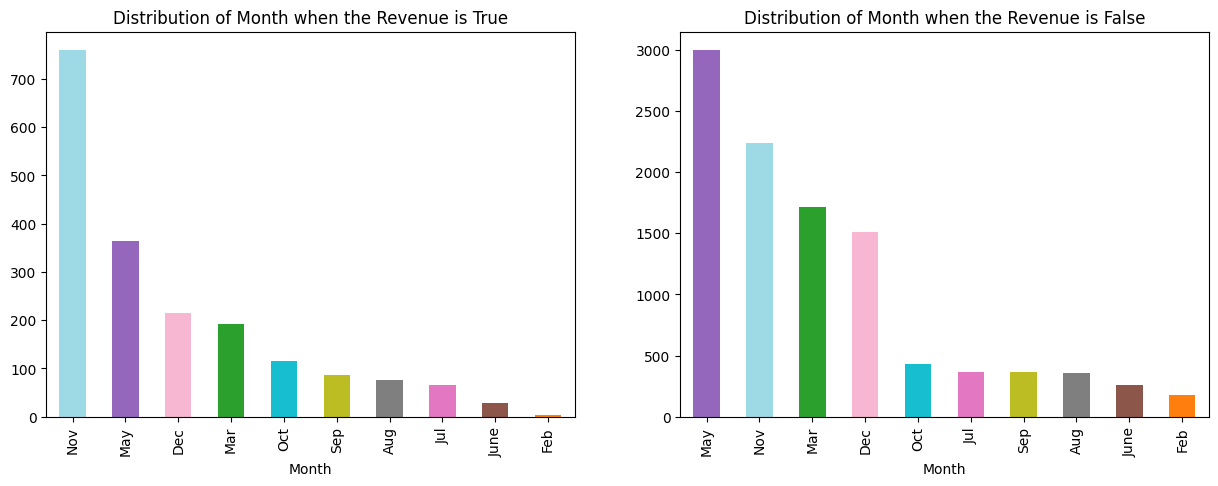

In [127]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

revenue_month_counts.plot(kind='bar', color=revenue_colors, ax=ax1)
not_revenue_month_counts.plot(kind='bar', color=not_revenue_colors, ax=ax2)

ax1.set_title('Distribution of Month when the Revenue is True')
ax2.set_title('Distribution of Month when the Revenue is False')

In [67]:
pd.get_dummies(df)['Revenue']

0        False
1        False
2        False
3        False
4        False
         ...  
12325    False
12326    False
12327    False
12328    False
12329    False
Name: Revenue, Length: 12330, dtype: bool